# Análise Inicial de Transações - Projeto AML/Fraud
Este notebook realiza a exploração inicial do dataset de transações simuladas.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados direto do GitHub
url = "https://raw.githubusercontent.com/a-bucci/AML---Fraud---AI---Portfolio/main/1_fiat_analysis/aml_fraud_risk_simulated_v1.csv"
df = pd.read_csv(url)

# Visualizar as 5 primeiras linhas
df.head()

,transaction_id,amount,account_age_days,transaction_hour,customer_risk_score,origin_country,destination_country,device_type,past_alerts
0,T0000,938.54,531,6,69,RU,RU,mobile,3
1,T0001,6020.24,988,16,82,FR,MX,desktop,0
2,T0002,2633.49,1198,19,29,BR,RU,desktop,2
3,T0003,1825.89,1254,8,70,NG,MX,mobile,2
4,T0004,339.25,958,16,73,NG,US,mobile,1


## Informações Gerais
Aqui analisamos dimensões, tipos de dados e valores ausentes.

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

## Distribuição de Variáveis
Visualizações para entender a distribuição de valores.

In [ ]:
plt.figure(figsize=(10, 6))
df['amount'].hist(bins=50)
plt.title('Distribuição de Valores de Transações')
plt.xlabel('Valor (USD)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='origin_country', order=df['origin_country'].value_counts().index)
plt.title('Origem das Transações')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

## Correlação entre variáveis numéricas

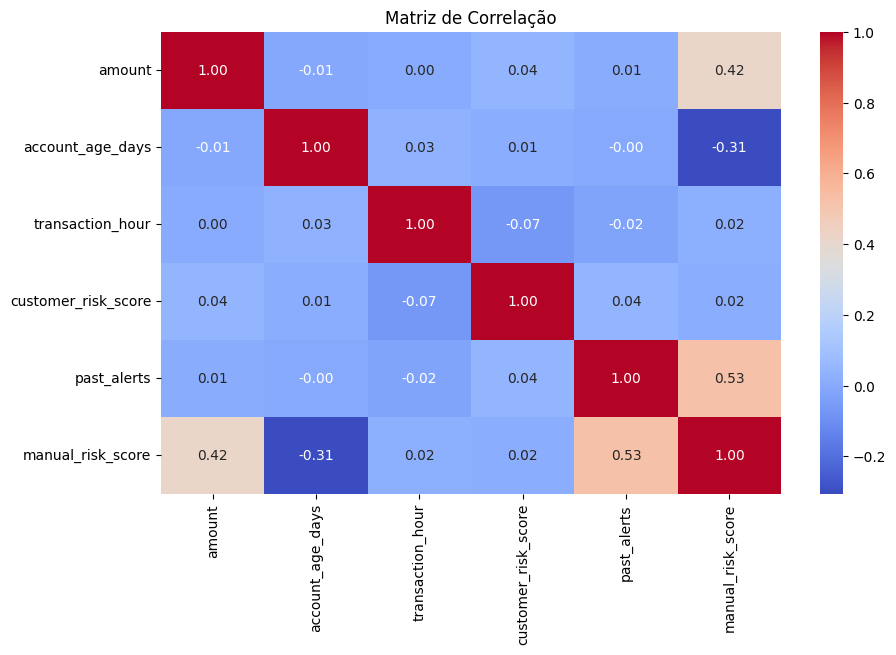

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Próximos passos:
- Criar score manual de risco com base em regras simples
- Gerar coluna `manual_risk_score`
- Analisar comportamento de alto risco

<ipython-input-58-972bf4cdb2a1>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='risk_level', data=df, palette=palette)


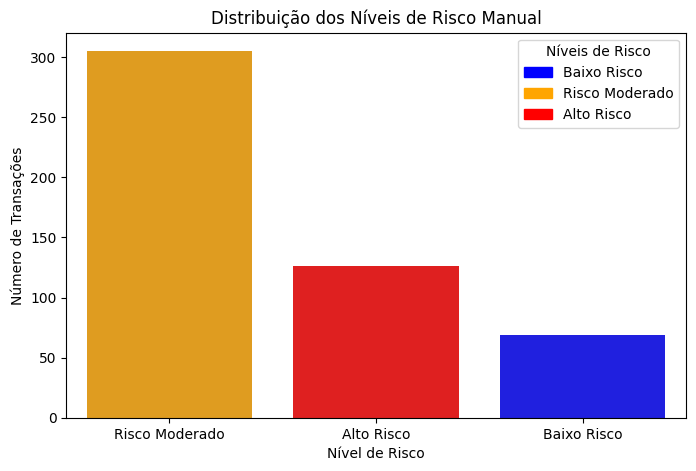

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Criar uma nova coluna para categorizar o risco manual em níveis
def categorize_risk(score):
    if score == 0:
        return 'Baixo Risco'
    elif 1 <= score <= 2:
        return 'Risco Moderado'
    else:
        return 'Alto Risco'

df['risk_level'] = df['manual_risk_score'].apply(categorize_risk)

# Definir cores para cada nível
palette = {
    'Baixo Risco': 'blue',
    'Risco Moderado': 'orange',
    'Alto Risco': 'red'
}

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='risk_level', data=df, palette=palette)
plt.title('Distribuição dos Níveis de Risco Manual')
plt.xlabel('Nível de Risco')
plt.ylabel('Número de Transações')

# Criar legenda automática com as cores usadas
handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
plt.legend(handles=handles, title='Níveis de Risco')

plt.show()


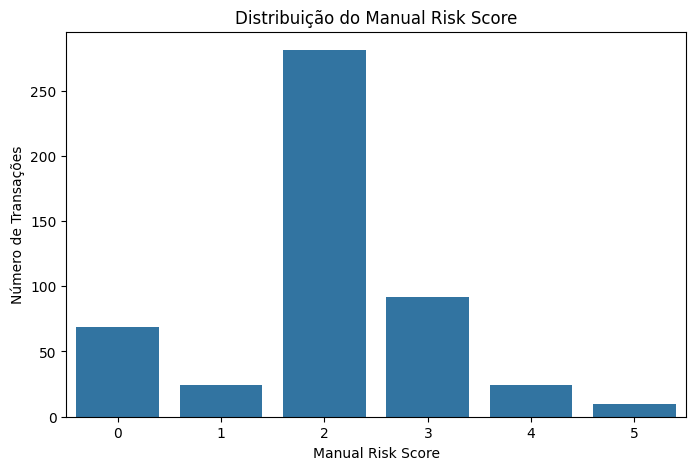

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='manual_risk_score', data=df)
plt.title('Distribuição do Manual Risk Score')
plt.xlabel('Manual Risk Score')
plt.ylabel('Número de Transações')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Selecionar as features que vamos usar no modelo (apenas numéricas)
features = ['amount', 'account_age_days', 'transaction_hour', 'past_alerts']

# Variável alvo: vamos tentar prever se a transação tem alto risco manual (por exemplo, manual_risk_score >= 3)
df['high_risk'] = (df['manual_risk_score'] >= 3).astype(int)

X = df[features]
y = df['high_risk']

# Dividir em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.95      0.98        22

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100

ROC-AUC: 0.9994172494172495


<Figure size 640x480 with 0 Axes>

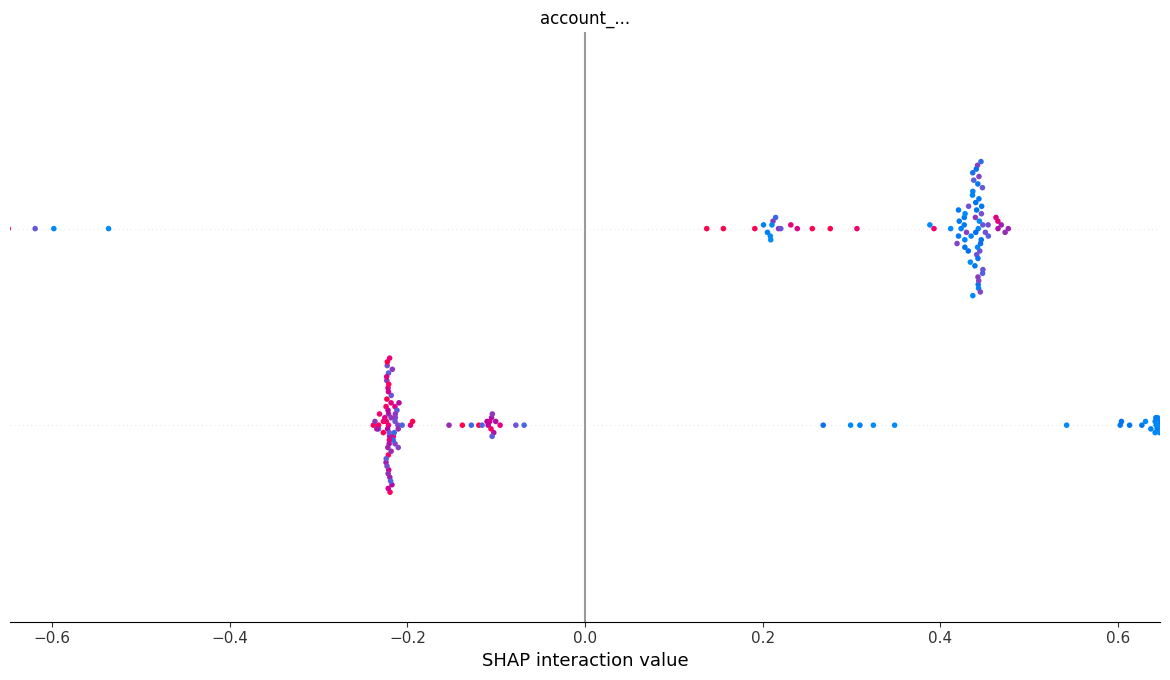

In [ ]:
import shap

# Criar o objeto explainer para Random Forest
explainer = shap.TreeExplainer(model)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Para modelos binários, shap_values é uma lista com duas matrizes (classe 0 e 1)
# Vamos usar a classe 1 (alto risco) para a visualização
shap.summary_plot(shap_values, X_test)



In [ ]:
!pip install --upgrade shap
